### Price Data Cleaning & Transformation
Chen Yang

In [40]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

RAW_DIR = Path("../../data/raw/price/source=yahoo")
CURATED_DIR = Path("../../data/curated/price/")
CURATED_DIR.mkdir(parents=True, exist_ok=True)

print("RAW DIR:     ", RAW_DIR.resolve())
print("CURATED DIR: ", CURATED_DIR.resolve())


RAW DIR:      /home/clsx6609/ds5110/data/raw/price/source=yahoo
CURATED DIR:  /home/clsx6609/ds5110/data/curated/price


In [41]:
all_files = sorted([p for p in RAW_DIR.rglob("*.parquet") if "/tmp/" not in str(p).replace("\\", "/")])
print(f"Found {len(all_files)} parquet files")

# preview first 5 files
all_files[:5]

Found 107 parquet files


[PosixPath('../../data/raw/price/source=yahoo/year=2017/month=01/part_2017-01_20170103_20170131.parquet'),
 PosixPath('../../data/raw/price/source=yahoo/year=2017/month=02/part_2017-02_20170201_20170228.parquet'),
 PosixPath('../../data/raw/price/source=yahoo/year=2017/month=03/part_2017-03_20170301_20170331.parquet'),
 PosixPath('../../data/raw/price/source=yahoo/year=2017/month=04/part_2017-04_20170403_20170428.parquet'),
 PosixPath('../../data/raw/price/source=yahoo/year=2017/month=05/part_2017-05_20170501_20170531.parquet')]

In [42]:
dfs = []

for f in tqdm(all_files, desc="Loading parquet files"):
    try:
        df_part = pd.read_parquet(f)
        dfs.append(df_part)
    except Exception as e:
        print(f"[WARN] failed to read {f}: {e}")

if not dfs:
    raise ValueError("No dataframes were loaded. Exiting.")

df = pd.concat(dfs, ignore_index=True)
print(f"Loaded rows: {len(df):,}, symbols: {df['symbol'].nunique() if 'symbol' in df.columns else 'N/A'}")
df.head()

Loading parquet files: 100%|██████████| 107/107 [00:00<00:00, 389.69it/s]


Loaded rows: 1,095,283, symbols: 503


,symbol,trade_date,open,high,low,close,adj_close,volume,dividends,split_ratio
0,A,2017-01-03 00:00:00-05:00,45.93,46.75,45.74,46.49,43.47,1739600,0.0,0.0
1,A,2017-01-04 00:00:00-05:00,46.93,47.38,46.82,47.10,44.04,1821300,0.0,0.0
2,A,2017-01-05 00:00:00-05:00,47.05,47.07,46.36,46.54,43.52,1503700,0.0,0.0
3,A,2017-01-06 00:00:00-05:00,46.63,48.07,46.56,47.99,44.87,2883400,0.0,0.0
4,A,2017-01-09 00:00:00-05:00,48.01,48.56,47.91,48.14,45.01,2575300,0.0,0.0


In [43]:
# Clean the dataframe

#1) check required columns
required = ["symbol", "trade_date", "open", "high", "low", "close", "adj_close", "volume", "dividends", "split_ratio"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

#2) drop duplicates
df = df.drop_duplicates(subset=["symbol", "trade_date"])

#3) drop rows with missing price or illegal values
df = df.dropna(subset=["close", "adj_close", "trade_date", "symbol"])
df = df[df["close"].astype(float) > 0]

#4) normalize symbols to uppercase
df["symbol"] = df["symbol"].astype(str).str.upper().str.strip()

# Show sample cleaned data
df

,symbol,trade_date,open,high,low,close,adj_close,volume,dividends,split_ratio
0,A,2017-01-03 00:00:00-05:00,45.93,46.75,45.74,46.49,43.47,1739600,0.0,0.0
1,A,2017-01-04 00:00:00-05:00,46.93,47.38,46.82,47.10,44.04,1821300,0.0,0.0
2,A,2017-01-05 00:00:00-05:00,47.05,47.07,46.36,46.54,43.52,1503700,0.0,0.0
3,A,2017-01-06 00:00:00-05:00,46.63,48.07,46.56,47.99,44.87,2883400,0.0,0.0
4,A,2017-01-09 00:00:00-05:00,48.01,48.56,47.91,48.14,45.01,2575300,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1095278,ZBRA,2025-11-06 00:00:00-05:00,265.77,267.98,256.79,258.24,258.24,530000,0.0,0.0
1095279,ZTS,2025-11-03 00:00:00-05:00,143.37,144.83,142.14,144.35,144.35,3994500,0.0,0.0
1095280,ZTS,2025-11-04 00:00:00-05:00,124.83,128.11,122.00,124.46,124.46,11921500,0.0,0.0
1095281,ZTS,2025-11-05 00:00:00-05:00,124.20,124.46,119.07,120.49,120.49,8355300,0.0,0.0


In [44]:
#5) convert trade_date to date and sort
df["trade_date"] = pd.to_datetime(df["trade_date"]).dt.date
df = df.sort_values(by=["symbol", "trade_date"]).reset_index(drop=True)

df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095283 entries, 0 to 1095282
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   symbol       1095283 non-null  object 
 1   trade_date   1095283 non-null  object 
 2   open         1095283 non-null  float64
 3   high         1095283 non-null  float64
 4   low          1095283 non-null  float64
 5   close        1095283 non-null  float64
 6   adj_close    1095283 non-null  float64
 7   volume       1095283 non-null  int64  
 8   dividends    1095283 non-null  float64
 9   split_ratio  1095283 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 83.6+ MB


,symbol,trade_date,open,high,low,close,adj_close,volume,dividends,split_ratio
0,A,2017-01-03,45.93,46.75,45.74,46.49,43.47,1739600,0.0,0.0
1,A,2017-01-04,46.93,47.38,46.82,47.10,44.04,1821300,0.0,0.0
2,A,2017-01-05,47.05,47.07,46.36,46.54,43.52,1503700,0.0,0.0
3,A,2017-01-06,46.63,48.07,46.56,47.99,44.87,2883400,0.0,0.0
4,A,2017-01-09,48.01,48.56,47.91,48.14,45.01,2575300,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,A,2017-05-19,56.09,56.32,55.86,56.13,52.62,1654400,0.0,0.0
96,A,2017-05-22,56.52,56.52,55.85,56.08,52.57,4264800,0.0,0.0
97,A,2017-05-23,59.80,59.98,58.00,58.66,54.99,7510600,0.0,0.0
98,A,2017-05-24,58.50,59.34,58.07,59.23,55.52,4060100,0.0,0.0


In [ ]:
#6) remove rows where volume is 0 or missing
mask_error = df["volume"].isna() | (df["volume"] == 0)
removed = mask_error.sum()
df = df[~mask_error].copy()
print(f"Removed {removed:,} rows where volume=0 or missing.")

Removed 1,424 rows where volume=0 or missing.


In [46]:
#7) remove rows with extreme daily returns > 80%
df["_ret"] = df.groupby("symbol")["adj_close"].pct_change()
mask_valid = (
    df["_ret"].between(-0.8, 0.8)
    | df["_ret"].isna()
)
df = df[mask_valid].copy()
df.drop(columns=["_ret"], inplace=True)

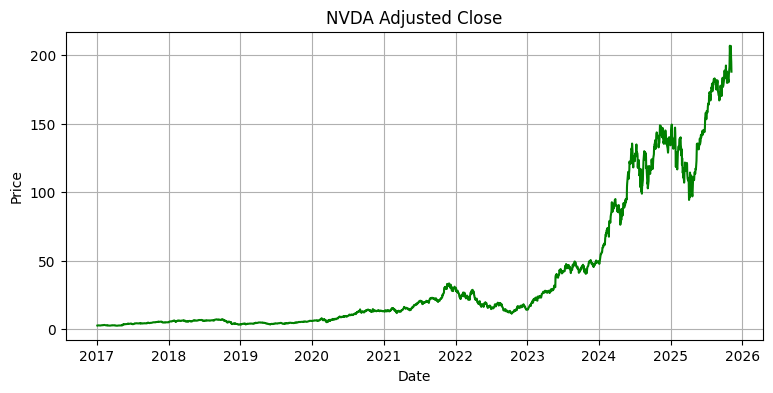

In [47]:
# Visualize a sample symbol
import matplotlib.pyplot as plt

sample_symbol = "NVDA"
s = df[df["symbol"] == sample_symbol]
plt.figure(figsize=(9,4))
plt.plot(s["trade_date"], s["adj_close"], label=sample_symbol, color="green")
plt.title(f"{sample_symbol} Adjusted Close")
plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.show()

In [48]:
#8) save cleaned data
output_path = CURATED_DIR / "prices_clean.parquet"
df.to_parquet(output_path, index=False)
print(f"Saved: {output_path}  | rows={len(df):,} | symbols={df['symbol'].nunique()}")

Saved: ../../data/curated/price/prices_clean.parquet  | rows=1,093,859 | symbols=503


In [49]:
summary = (
    df.agg(
        rows=("symbol","size"),
        symbols=("symbol","nunique")
    )
    .T
)
summary["start_date"] = df["trade_date"].min()
summary["end_date"]   = df["trade_date"].max()
summary

,rows,symbols,start_date,end_date
symbol,1093859,503,2017-01-03,2025-11-06
